**Goal**: Compute descriptive info on the dataset of quantum programs.

# Dataset Statistics (Qiskit and Cirq)

In [103]:
import project_path
from rdlib import *  # this imports the base libraries

import glob
from typing import Dict, List
import re
import yaml


In [76]:
# dataset
DIR_DATASET_QISKIT = '../data/datasets/exp_v08'
LOG_FILE_QUERIES = '../data/analysis_results/exp_v08/codeql_2023-03-20_19-13-27/log.txt'
LOG_FILE_DB_CREATION = '../data/datasets/exp_v08/log_codeql.txt'

# output
PAPER_DIR = '../data/paper_images'

# Abstraction
DETECTORS_FOLDER = '../qlint/codeql/src'
ABSTRACTION_FOLDER = '../qlint/codeql/lib/qiskit'

# warning & manual inspection
PATH_WARNINGS_SARIF = '../data/analysis_results/exp_v08/codeql_2023-03-20_19-13-27/data.sarif'
PATH_MANUAL_INSPECTION_CSV = '../data/annotations/manual_inspection/warnings_until_23_03_28.csv'
PATH_METADATA_DATASET = '../data/datasets/exp_v08/df_summary.csv'
PATH_WARNINGS_CSV_NEW = PATH_WARNINGS_SARIF.replace(".sarif", ".csv")

# competitor
PATH_QSMELL_RESULTS = "../data/datasets/exp_v08/qsmell"

# BLACKLIST OF DATA WHICH REFER TO OBSOLETE INSPECTIONS/ IMPLEMENTATIONS
BLACKLIST_EXPERIMENTS = ['exp_v00']
BLACKLISTED_QUERIES = [
    '/Vulnerability/TokenLeakage.ql',
    '/Simulation/InvalidPauliErrorSize.ql',
    '/Simulation/InvalidPauliSyntaxError.ql',]
BLACKLISTED_RULES = [
    'ql-token-leakage',
    'ql-invalid-pauli-size-error',
    'ql-invalid-pauli-string',
]
BLACKLISTED_ABSTRACTION = [
    '/SensitiveAPI.qll',
    '/NoiseModel.qll',
    '/Pauli.qll',
]

# NAME MAPPING: for uniformity of names
NAME_MAPPING = {
    'ql-double-measurement': 'DoubleMeas',
    'DoubleMeasurement.ql': 'DoubleMeas',

    'ql-operation-after-measurement': 'OpAfterMeas',
    'OpAfterMeasurement.ql': 'OpAfterMeas',

    'ql-measure-all-abuse': 'MeasAllAbuse',
    'MeasureAll.ql': 'MeasAllAbuse',


    'ql-incompatible-composition': 'IncompCompose',
    'IncompatibleComposition.ql': 'IncompCompose',

    'ql-ungoverned-composition': 'UngovCompose',
    'UngovernedComposition.ql': 'UngovCompose',

    'ql-ghost-composition': 'GhostCompose',
    'GhostComposition.ql': 'GhostCompose',


    'ql-unmeasurable-qubits': 'InsuffClasReg',
    'UnmeasurableQubits.ql': 'InsuffClasReg',

    'ql-oversized-circuit': 'OversizedCircuit',
    'OversizedCircuit.ql': 'OversizedCircuit',

    'ql-op-after-optimization': 'OpAfterTransp',
    'OpAfterOptimization.ql': 'OpAfterTransp',


    'qsmell-nc': 'QSmellNC',
    'qsmell-lpq': 'QSmellLPQ',


    # 'InvalidPauliErrorSize.ql': 'InvPauliError',
    # 'ql-invalid-pauli-size-error': 'InvPauliError',

    # 'InvalidPauliSyntaxError.ql': 'InvPauliSyntax',
    # 'ql-invalid-pauli-string': 'InvPauliSyntax',
}


RULE_NAME_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() 
    if k.startswith('ql-') or k.startswith('qsmell-')
}
FILE_NAME_RULE_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() 
    if k.endswith('.ql')
}


In [119]:
# PLOT THE FILTERING STEPS OF THE DATASET
PATH_YAML_EXPERIMENT = '../config/dataset_creation_exp_v08.yaml'
with open(PATH_YAML_EXPERIMENT, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
# ../data/datasets/exp_v08/intermediate_results
names_of_processing_steps = [p['name'] for p in config['processing_steps']]
n_files_prev_step = None
for step_name in names_of_processing_steps:
    step_dir = os.path.join(
        "..", config['dataset_folder'], 
        'intermediate_results', step_name, "files")
    # remove _ and space capitalize the first letter of each word
    step_name = step_name.replace("_", " ").title().replace(" ", "")
    n_files_in_dir = len([
        f for f in os.listdir(step_dir) 
        if os.path.isfile(
            os.path.join(step_dir, f)
        )])
    # print the number of files in the format 1'000
    print("\\newcommand{\\" + step_name + "}{" + f"{n_files_in_dir:,}" + "}")
    if n_files_prev_step is not None:
        # compute the percentage reduction with respect to the previous step
        perc_red = ((n_files_prev_step - n_files_in_dir) / n_files_prev_step) * 100
        print("\\newcommand{\\" + step_name + "Reduction}{" + f"{perc_red:.1f}\%" + "}")

    n_files_prev_step = n_files_in_dir

\newcommand{\RemoveTooLongFilenames}{81,862}
\newcommand{\KeepOnlyPyAndIpynb}{75,304}
\newcommand{\KeepOnlyPyAndIpynbReduction}{8.0\%}
\newcommand{\RemoveBlacklistedRepos}{41,739}
\newcommand{\RemoveBlacklistedReposReduction}{44.6\%}
\newcommand{\ConvertIpynbToContentOnly}{36,614}
\newcommand{\ConvertIpynbToContentOnlyReduction}{12.3\%}
\newcommand{\Parsable}{19,260}
\newcommand{\ParsableReduction}{47.4\%}
\newcommand{\AddHashOfTheContent}{19,260}
\newcommand{\AddHashOfTheContentReduction}{0.0\%}
\newcommand{\HashDeduplication}{14,494}
\newcommand{\HashDeduplicationReduction}{24.7\%}
\newcommand{\IncludeImport}{8,743}
\newcommand{\IncludeImportReduction}{39.7\%}
\newcommand{\ExcludePlatformCode}{7,587}
\newcommand{\ExcludePlatformCodeReduction}{13.2\%}
\newcommand{\UnrollLoops}{7,567}
\newcommand{\UnrollLoopsReduction}{0.3\%}


## Helper Function

In [54]:
import os

def get_file_extension_dictionary(dir: str) -> dict:
    """Get a dictionary {filename: its extension, etc.} form a directory."""
    file_extensions = {}
    for file in os.listdir(dir):
        base_name = os.path.splitext(file)[0]
        extension = os.path.splitext(file)[1]
        file_extensions[base_name] = extension
    return file_extensions

def create_pandas(file_extensions: dict) -> pd.DataFrame:
    """Create a pandas dataframe from a dictionary {filename: its extension, etc.}."""
    df = pd.DataFrame.from_dict(file_extensions, orient='index', columns=['extension'])
    df['filename'] = df.index
    # drop index
    df.reset_index(drop=True, inplace=True)
    df['filename'] = df['filename'].astype(str)
    df['extension'] = df['extension'].astype(str)
    return df

def get_stats_on(dataset_folder: str, platform_name: str):
    """Print the summary stats of the given folder."""

    ext_dict_selected = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'files_selected'))
    df_selected = create_pandas(ext_dict_selected)

    ext_dict_all = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'raw_files'))
    df_all = create_pandas(ext_dict_all)

    df_merged = pd.merge(
        df_selected, df_all, 
        on='filename', how='left',
        suffixes=('_selected', '_all'))

    # countplot with percentage of py and ipynb files
    total_unique_files = df_merged.shape[0]
    total_raw_files = df_all.shape[0]
    perc_py = (df_merged[df_merged['extension_all'] == '.py'].shape[0] / total_unique_files) * 100
    perc_ipynb = (df_merged[df_merged['extension_all'] == '.ipynb'].shape[0] / total_unique_files) * 100
    print(f'Percentage of .py files: {perc_py:.1f} %')
    print(f'Percentage of .ipynb files: {perc_ipynb:.1f} %')
    print(f'Total unique files: {total_unique_files}')
    print(f'Total files (scraped): {total_raw_files}')

    print("\\newcommand{\\nProgramsScraped" + platform_name + "}{" + f"{total_raw_files:,}" + "}")
    print("\\newcommand{\\nProgramsSelected" + platform_name + "}{" + f"{total_unique_files:,}" + "}")
    print("\\newcommand{\\nProgramsPy" + platform_name + "}{" + f"{perc_py:.1f}" + "\%}")
    print("\\newcommand{\\nProgramsIpynb" + platform_name + "}{" + f"{perc_ipynb:.1f}" + "\%}")
    
    fig, ax = plt.subplots(figsize=(5, 1.5))
    sns.countplot(
        data=df_merged, 
        y='extension_all',
        order=['.py', '.ipynb'],
        ax=ax,
    )
    plt.xlabel('Number of programs')
    plt.ylabel('Extension')
    plt.tight_layout()
    fig.savefig(
        os.path.join(PAPER_DIR, f'files_per_extension_{platform_name}.pdf'))
    

## Read Data

In [55]:
df_inspected_warnings = pd.read_csv(PATH_MANUAL_INSPECTION_CSV)
# filter out old runs of experiments
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["experiment"].isin(BLACKLIST_EXPERIMENTS)]
# filter out blacklisted outdated checkers
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["detector_rule"].isin(BLACKLISTED_RULES)]
# map the detector_rule with dict: RULE_NAME_MAPPING
df_inspected_warnings['detector_rule'] = \
    df_inspected_warnings['detector_rule'].map(RULE_NAME_MAPPING)
df_inspected_warnings.head()


# count how many files we have in the dataset
ext_dict_selected = get_file_extension_dictionary(
    dir=os.path.join(DIR_DATASET_QISKIT, 'files_selected'))
df_selected = create_pandas(ext_dict_selected)
ext_dict_all = get_file_extension_dictionary(
    dir=os.path.join(DIR_DATASET_QISKIT, 'raw_files'))
df_all = create_pandas(ext_dict_all)
df_merged = pd.merge(
    df_selected, df_all, 
    on='filename', how='left',
    suffixes=('_selected', '_all'))
TOTAL_FILES_IN_DATASET = df_merged.shape[0]
print(f"Total files in dataset: {TOTAL_FILES_IN_DATASET}")

Total files in dataset: 7568


Percentage of .py files: 85.8 %
Percentage of .ipynb files: 14.2 %
Total unique files: 7568
Total files (scraped): 81862
\newcommand{\nProgramsScrapedQiskit}{81,862}
\newcommand{\nProgramsSelectedQiskit}{7,568}
\newcommand{\nProgramsPyQiskit}{85.8\%}
\newcommand{\nProgramsIpynbQiskit}{14.2\%}


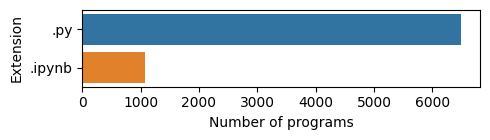

In [56]:
get_stats_on(
    dataset_folder=DIR_DATASET_QISKIT,
    platform_name='Qiskit')

## RQ1: Modeling Info: Abstractions and Queries
- How many CodeQL LoC per checker. 
- Avg number of abstractions used. >> bipartite graph.


In [57]:
def read_files(folder: str, extension: str = ".ql") -> Dict[str, str]:
    """Read all files with the given extension in the folder and subfolders."""
    ql_files = {}
    for file in glob.glob(folder + f'/**/*{extension}', recursive=True):
        with open(file, 'r') as f:
            content = f.read()
            ql_files[file.replace(folder, "")] = content
    return ql_files

def get_abstractions_used(content: str) -> List[str]:
    """Get the abstractions used in the given content."""
    abstractions = []
    for line in content.splitlines():
        if line.startswith('import'):
            abstraction = line.split(' ')[1]
            abstractions.append(abstraction)
    return abstractions

In [58]:
query_files = read_files(
    folder=DETECTORS_FOLDER, extension='.ql')
abstraction_files = read_files(
    folder=ABSTRACTION_FOLDER, extension='.qll')

# remove all the blacklisted queries
query_files = {
    k: v for k, v in query_files.items() 
    if k not in BLACKLISTED_QUERIES}

# remove all the blacklisted abstractions
abstraction_files = {
    k: v for k, v in abstraction_files.items() 
    if k not in BLACKLISTED_ABSTRACTION}

print(f'Number of queries: {len(query_files)}')
print(f'Number of abstractions: {len(abstraction_files)}')
all_query_names = list(query_files.keys())
print(all_query_names)

all_abstractions_names = list(abstraction_files.keys())
print(all_abstractions_names)

Number of queries: 11
Number of abstractions: 4
['/Measurement/OpAfterMeasurement.ql', '/Measurement/MeasureAll.ql', '/Measurement/DoubleMeasurement.ql', '/Qsmell/NoAlignmentLogicalPhysical.ql', '/Qsmell/NonParametrizedCircuit.ql', '/Resource/OversizedCircuit.ql', '/Resource/UnmeasurableQubits.ql', '/Interconnection/IncompatibleComposition.ql', '/Interconnection/UngovernedComposition.ql', '/Interconnection/GhostComposition.ql', '/Optimization/OpAfterOptimization.ql']
['/Register.qll', '/Qubit.qll', '/Circuit.qll', '/Gate.qll']


### RQ1.A Which abstractions are used in the different queries?

In [59]:
def get_abstractions_from_qll(content: str) -> List[str]:
    """Get the abstractions used in the given content.
    
    It uses regex."""
    # all_abstractions = re.findall(r'class (\w+)', content)
    public_abstractions = re.findall(r'^class (\w+)', content, re.MULTILINE)
    return public_abstractions

all_abstraction_defined = []
for abstraction_file in abstraction_files.values():
    all_abstraction_defined += get_abstractions_from_qll(abstraction_file)

print(f'Number of abstractions defined: {len(all_abstraction_defined)}')
print(all_abstraction_defined)

Number of abstractions defined: 9
['ClassicalRegister', 'QuantumRegister', 'QubitUsedInteger', 'QuantumCircuit', 'TranspiledCircuit', 'Gate', 'MeasureGate', 'MeasurementAll', 'MeasurementAny']


In [60]:
def check_abstractions_used(abstraction: List[str], content: str) -> bool:
    """Check if the given abstraction is used in the content.
    
    Via regex.
    """
    abstractions_used = []
    for a in abstraction:
        if re.search(rf'\b{a}\b', content):
            abstractions_used.append(a)
    return abstractions_used


query_to_abstraction = {}

# remove Qsmell classes
query_files = {
    k: v for k, v in query_files.items() 
    if not k.startswith('/Qsmell/')}

for query_name, query_content in query_files.items():
    abstractions_used = check_abstractions_used(
        abstraction=all_abstraction_defined, 
        content=query_content)
    if abstractions_used:
        base_name = os.path.basename(query_name)
        if base_name in FILE_NAME_RULE_MAPPING:
            base_name = FILE_NAME_RULE_MAPPING[base_name]
        query_to_abstraction[base_name] = abstractions_used
        print(f'{query_name}: {abstractions_used}')


/Measurement/OpAfterMeasurement.ql: ['Gate', 'MeasureGate']
/Measurement/MeasureAll.ql: ['QuantumCircuit', 'MeasurementAll']
/Measurement/DoubleMeasurement.ql: ['Gate', 'MeasureGate']
/Resource/OversizedCircuit.ql: ['QuantumRegister', 'QubitUsedInteger', 'QuantumCircuit', 'MeasureGate']
/Resource/UnmeasurableQubits.ql: ['QuantumRegister', 'QuantumCircuit']
/Interconnection/IncompatibleComposition.ql: ['QuantumCircuit']
/Interconnection/UngovernedComposition.ql: ['QuantumCircuit']
/Interconnection/GhostComposition.ql: ['QuantumCircuit']
/Optimization/OpAfterOptimization.ql: ['TranspiledCircuit', 'Gate']


,source,target,type,value
0,OpAfterMeas,Gate,use,1
1,OpAfterMeas,MeasureGate,use,1
2,MeasAllAbuse,QuantumCircuit,use,1
3,MeasAllAbuse,MeasurementAll,use,1
4,DoubleMeas,Gate,use,1


\newcommand{\avgAbstractionsUsedPerQuery}{1.5}
\newcommand{\avgQueriesSupportedPerAbstraction}{2.4}


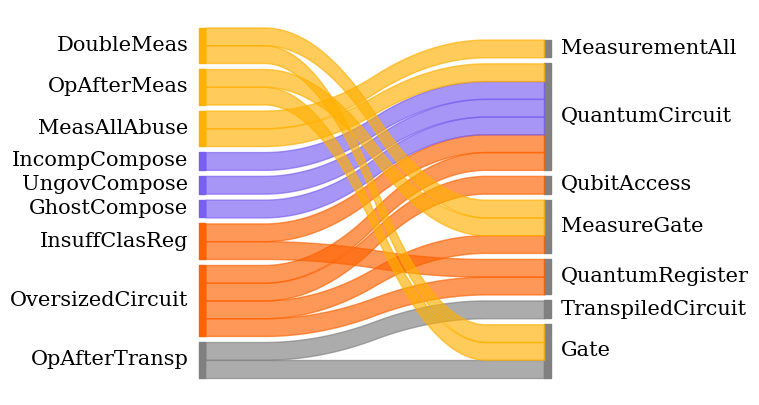

In [102]:
# get matplotlib rc configuration
rc = plt.rcParams.copy()

from pySankey.sankey import sankey
# source,target,type,value

records = []
for query_name, abstractions in query_to_abstraction.items():
    for abstraction in abstractions:
        if abstraction == "QubitUsedInteger":
            abstraction = "QubitAccess"
        records.append({
            'source': query_name,
            'target': abstraction,
            'type': 'use',
            'value': 1,
        })
df_abstractions = pd.DataFrame.from_records(records)
display(df_abstractions.head())
# sort by canonical order
df_abstractions['source'] = pd.Categorical(
    df_abstractions['source'],
    categories=RULE_NAME_MAPPING.values()
)
df_abstractions = df_abstractions.sort_values('source', ascending=False)
df_abstractions.head()
# compute the average number of records per source 
use_relationship_per_query = df_abstractions.groupby('source').count()['value']
#print(use_relationship_per_query)
avg_use_relationship_per_query = use_relationship_per_query.mean()
print("\\newcommand{\\avgAbstractionsUsedPerQuery}{" + f"{avg_use_relationship_per_query:.1f}" + "}")
avg_use_relationship_per_abstraction = df_abstractions.groupby('target').count()['value'].mean()
print("\\newcommand{\\avgQueriesSupportedPerAbstraction}{" + f"{avg_use_relationship_per_abstraction:.1f}" + "}")

# create thematic groups for source
color_themes = {
    "pauli": "#dc267f",
    "compos": "#785ef0",
    "insuf": "#fe6100", 
    "oversize": "#fe6100",
    "[^u]?meas": "#ffb001",    
}
per_family_color = {}
for row in df_abstractions.iterrows():
    query_name = row[1]['source']
    # default
    per_family_color[query_name] = "grey"
    for k in color_themes.keys():
        if re.search(k, query_name.lower()):
            per_family_color[query_name] = color_themes[k]
            break

# colorDict: yellow for target and blue for source
colorDict = {
    #**{k: 'slateblue' for k in df_abstractions['source'].unique()}, 
    **per_family_color,
    **{k: 'gray' for k in df_abstractions['target'].unique()}
}

sankey(
    left=df_abstractions['source'],
    right=df_abstractions['target'],
    aspect=20,
    colorDict=colorDict,
    fontsize=15,
)
plt.gcf().set_size_inches(5, 5)
plt.savefig(
    os.path.join(PAPER_DIR, 'sankey_abstraction.pdf'),
    bbox_inches='tight')

# go back to the initial rc configuration
plt.rcParams.update(rc)

### RQ1.B Count LoC Files

\newcommand{\avgLoCQuery}{13}
\newcommand{\minLoCQuery}{6}
\newcommand{\maxLoCQuery}{20}


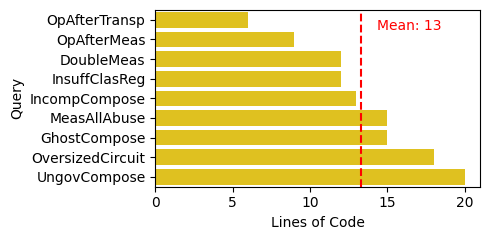

In [62]:
SHOW_QUERIES_DEBUG = False

records = []
for query_name, query_content in query_files.items():
    # count the lines in the content excluding the imports and the comment lines
    # comment start with: /* or * or //
    # imports start with: import
    lines = query_content.splitlines()
    lines = [
        line for line in lines
        # use regex to ensure we account for spaces
        if not re.match(r'^\s*import', line) and
        not re.match(r'^\s*//', line) and
        not re.match(r'^\s*\*', line) and
        not re.match(r'^\s*/\*', line)  
    ]
    # remove empty lines
    lines = [l for l in lines if l != '']
    loc = len(lines)
    if SHOW_QUERIES_DEBUG:
        print("\n".join(lines))
        print(query_name, loc)
        # check that none of the line is longer than 80 chars
        for line in lines:
            if len(line) > 80:
                print("___________________ line too long: ", line)
    base_query_name = os.path.basename(query_name)
    records.append({
        'query_name': FILE_NAME_RULE_MAPPING[base_query_name],
        'loc': loc
    })

df_loc_queries = pd.DataFrame.from_records(records)

# plot the lines of code histogram
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.barplot(
    data=df_loc_queries,
    y='query_name',
    x='loc',
    color='gold',
    # sort
    order=df_loc_queries.sort_values('loc', ascending=True)['query_name'],
)
ax.set_xlabel('Lines of Code')
ax.set_ylabel('Query')
mean_value = df_loc_queries['loc'].mean()
# add red line for the mean
ax.axvline(mean_value, color='red', linestyle='--')
# plot the label of the mean
ax.text(
    mean_value + 1,
    0.5,
    f'Mean: {mean_value:.0f}',
    color='red',
)
plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, 'loc_queries.pdf')
)
print("\\newcommand{\\avgLoCQuery}{" + f"{mean_value:.0f}" + "}")
min_value = df_loc_queries['loc'].min()
print("\\newcommand{\\minLoCQuery}{" + f"{min_value:.0f}" + "}")
max_value = df_loc_queries['loc'].max()
print("\\newcommand{\\maxLoCQuery}{" + f"{max_value:.0f}" + "}")


## RQ2: Real Bugs Found

In [63]:
# create latex table
from copy import deepcopy
import string

df_bugs = pd.read_csv(PATH_MANUAL_INSPECTION_CSV)
df_bugs = df_bugs.sort_values(by=[
    "status", "detector_rule"
], ascending=[True, False])
df_bugs = df_bugs.reset_index(drop=True)
df_bugs = df_bugs.reset_index(drop=False)
df_bugs = df_bugs.fillna("-")

ANONYMOUS = True
REMOVE_FALSE_POSITIVES = True
REMOVE_NOTEWORTHY = True
REMOVE_UNANNOTATED = True

# remove blacklisted detecotrs
df_bugs = df_bugs[~df_bugs["detector_rule"].isin(BLACKLISTED_RULES)]

col_renaming = {
    "index": "ID",
    "problem_description": "Problem description",
    "detector_rule": "Checker",
    #"API_usage": "API usage",
    "manifestation": "Manifestation",
    #"component": "Where",
    "problem_id": "Problem ID",
    "link_to_issue": "Issue",
    "status": "Status",
    #"known_before": "Novelty",
    #"triage": "Triage",
}

if ANONYMOUS:
    # remove the key "link_to_issue" from the dictionary
    del col_renaming["link_to_issue"]
    col_renaming["problem_id"] = "Issue"
    column_format = '@{}lp{7.3cm}p{2.5cm}lll@{}'
else:
    column_format = '@{}rlp{7.3cm}p{2.5cm}lll@{}'

pd.set_option('display.max_colwidth', 1000)

relevant_columns = col_renaming.keys()
df_table = deepcopy(df_bugs)
if REMOVE_FALSE_POSITIVES:
    df_table = df_table[~(df_table["triage"] == "FP")]
if REMOVE_NOTEWORTHY:
    df_table = df_table[~(df_table["triage"] == "Noteworthy")]
if REMOVE_UNANNOTATED:
    df_table = df_table[~(df_table["triage"] == "-")]
df_table = df_table.drop(columns='index')  

# def replace_MR_names(transf_str):
#     new_transf_str = transf_str
#     for k, v in MR_ALIAS.items():
#         new_transf_str = new_transf_str.replace(k, v)
#     return new_transf_str

# df_table["mr_used"] = df_table["mr_used"].apply(
#     lambda e: replace_MR_names(transf_str=e)
# ) 


# replace fixed with the url and fixed
df_table["status"] = df_table["status"].apply(
    lambda e: "fixed" if "fixed" in e else e
)

df_table = df_table.reset_index(drop=True)
df_table = df_table.reset_index(drop=False)
df_table = df_table[relevant_columns].rename(columns=col_renaming)
df_table["ID"] = df_table["ID"].apply(lambda e: int(e) + 1)
# cut the column with detector
df_table["Checker"] = df_table["Checker"].map(RULE_NAME_MAPPING)
# sort by Detector

mapping_numbers = {
    "1": "One",
    "2": "Two",
    "3": "Thr",
    "4": "Fou",
    "5": "Fiv",
    "6": "Six",
    "7": "Sev",
    "8": "Eig",
    "9": "Nin",
    "0": "Zer",
}

print("% RQ2")
for i, row in df_table.iterrows():
    msg = row["Issue"]
    # remove underscores
    msg = msg.replace("_", "")
    for k, v in mapping_numbers.items():
        msg = msg.replace(k, v)
    # msg = msg.translate(str.maketrans('', '', string.punctuation))
    # msg = ''.join([w.capitalize() for w in msg.lower().split()])
    # msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

print("")
table_code = df_table.to_latex(
    column_format=column_format,
    index=False)
table_code = re.sub("\s'", " `", table_code)
# replace all links with a \url{} command
table_code = re.sub("(https:[^ ]*)", r"\\href{\1}{link}", table_code)
print(table_code)
df_table

% RQ2
\newcommand{\IDZerEigcFivZerSevThrFouFouOneTwo}{1}
\newcommand{\IDZerSixfeSixZerZerNinSixThr}{2}
\newcommand{\IDZerSixOneThrbaEigZerNinZer}{3}
\newcommand{\IDZerSixOneThrbaEigZerOneZerSev}{4}
\newcommand{\IDZerSixFoucNinFouFouThrThrFiv}{5}
\newcommand{\IDZerSixOneSevfeFouSevOneEig}{6}
\newcommand{\IDZerEigcFoucThrFoufFivNin}{7}
\newcommand{\IDZerEigcFoucThrFoufSixFou}{8}
\newcommand{\IDZerEigNinTwoThrTwoeaFivFiv}{9}
\newcommand{\IDZerSixcFoucThrFoufFouFiv}{10}
\newcommand{\IDZerSixcFoucThrFoufFouZer}{11}
\newcommand{\IDZerSixFivFivfdZerSevTwoFiv}{12}
\newcommand{\IDZerSixSevafThrThrTwoThrFiv}{13}
\newcommand{\IDZerSixZerNinbeZerThrOneNin}{14}
\newcommand{\IDZerSixdfSixZerEigfThrTwoTwo}{15}
\newcommand{\IDZerSixfTwoEigThrbfTwoFivFouThr}{16}
\newcommand{\IDZerSixfSixEigSixZerSevTwoOneNin}{17}
\newcommand{\IDZerSixFivbEigbeSixTwoSev}{18}
\newcommand{\IDZerSixSevcEigNinbeOneFiv}{19}
\newcommand{\IDZerSixcSevEigTwoFivcOneEig}{20}
\newcommand{\IDZerSixcffOneOneaFivThr}{21}
\newcommand{

/tmp/ipykernel_6288/2753966189.py:106: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_code = df_table.to_latex(


,ID,Problem description,Checker,Manifestation,Issue,Status
0,1,Measure all generates a twice as long output,MeasAllAbuse,silent,08_c50734_412,confirmed
1,2,Redundant measurment,DoubleMeas,silent,06_fe6009_63,fixed
2,3,Missing compose assignment in a test case,GhostCompose,silent,06_13ba80_90,fixed
3,4,Missing compose assignment in a test case,GhostCompose,silent,06_13ba80_107,fixed
4,5,Unused qubit,OversizedCircuit,silent,06_4c9443_35,reported
5,6,Gate after measurement in wrong OR implementation,OpAfterMeas,silent,06_17fe47_18,reported
6,7,Measure gate added to a transpiled circuit,OpAfterTransp,silent,08_c4c34f_59,reported
7,8,Measure gate added to a transpiled circuit,OpAfterTransp,silent,08_c4c34f_64,reported
8,9,Grover algo: measure gate added after transpilation,OpAfterTransp,silent,08_9232ea_55,reported
9,10,Measure gate added to a transpiled circuit,OpAfterTransp,silent,06_c4c34f_45,reported


## RQ3: False Positives Found

### RQ3.A: How many warnings are generated per query?

In [4]:
! sarif csv --output {PATH_WARNINGS_CSV_NEW} {PATH_WARNINGS_SARIF}

Writing CSV summary for data.sarif to data.csv


In [64]:
df_metadata = pd.read_csv(PATH_METADATA_DATASET)
print(df_metadata.columns)
df_metadata['unique_id'] = df_metadata.apply(
    lambda row: str(row['filestem']) + "_" + str(row['hash']),
    axis=1
)
df_metadata = df_metadata[['unique_id', 'extension', 'repository_name']]
df_metadata.head()

Index(['download_url', 'html_url', 'name', 'path', 'repository_description',
       'repository_fork', 'repository_name', 'repository_owner_url',
       'repository_url', 'score', 'filename', 'extension', 'filestem', 'hash',
       'unique_id'],
      dtype='object')


,unique_id,extension,repository_name
0,test_sabre_swap_95cbde,py,sethuquantum/LearnQuantum
1,B01_Qiskit_Reference-checkpoint_9b754a,ipynb,QRussia/basics-of-quantum-computing-translate
2,quantum_generator_d6f5f2,py,roytu/QOSF-FeMoco2020
3,B01_Qiskit_Reference_c78ae2,ipynb,Abdoelabassi/Qbronze
4,pulse_instruction_f43374,py,904194705/Qiskit-RIKEN-project-


In [65]:
df_warnings = pd.read_csv(PATH_WARNINGS_CSV_NEW)
df_warnings['rule'] = df_warnings['Code'].apply(lambda e: e.split(" ")[0])
df_warnings['unique_id'] = df_warnings['Location'].apply(lambda e: e.split(".")[0])
df_warnings.head(1)

,Tool,Severity,Code,Location,Line,rule,unique_id
0,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (10, 1) and (11, 1)",example_d675c9.py,11,ql-double-measurement,example_d675c9
1,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (10, 1) and (12, 1)\nTwo consecutive measurements on qubit 'IntegerLiteral' at locations: (11, 1) and (12, 1)",example_d675c9.py,12,ql-double-measurement,example_d675c9
2,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (107, 1) and (108, 1)",02_measurements_and_mixed_states_qiskit_ee25f6.py,108,ql-double-measurement,02_measurements_and_mixed_states_qiskit_ee25f6
3,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (11, 1) and (12, 1)",qubitstates_903372.py,12,ql-double-measurement,qubitstates_903372
4,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (121, 1) and (123, 1)",computaci_c3_b3n_cu_c3_a1ntica_pr_c3_a1ctica_cs2022_cfd1a4.py,123,ql-double-measurement,computaci_c3_b3n_cu_c3_a1ntica_pr_c3_a1ctica_cs2022_cfd1a4


In [66]:
# merge the two dataframes keeping the df_warnings as the base
df_merged = pd.merge(
    df_warnings,
    df_metadata,
    on='unique_id',
    how='left'
)
# remove blacklist rules
df_merged = df_merged[~df_merged['rule'].isin(BLACKLISTED_RULES)]
df_lintq_only = df_merged[df_merged['rule'].str.startswith('ql')]
df_lintq_only['rule'] = df_lintq_only['rule'].map(RULE_NAME_MAPPING)
df_lintq_checker_location = df_lintq_only[['rule', 'Location']]
print(df_lintq_checker_location['rule'].unique())
df_lintq_checker_location.head()

['DoubleMeas' 'GhostCompose' 'IncompCompose' 'MeasAllAbuse'
 'OpAfterTransp' 'OpAfterMeas' 'OversizedCircuit' 'InsuffClasReg']


/tmp/ipykernel_6288/2940217710.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lintq_only['rule'] = df_lintq_only['rule'].map(RULE_NAME_MAPPING)


,rule,Location
0,DoubleMeas,example_d675c9.py
1,DoubleMeas,example_d675c9.py
2,DoubleMeas,02_measurements_and_mixed_states_qiskit_ee25f6.py
3,DoubleMeas,qubitstates_903372.py
4,DoubleMeas,computaci_c3_b3n_cu_c3_a1ntica_pr_c3_a1ctica_cs2022_cfd1a4.py


In [67]:

all_csv_files = [
    os.path.join(PATH_QSMELL_RESULTS, f)
    for f in os.listdir(PATH_QSMELL_RESULTS)
    if f.endswith(".csv")
]
df_qsmell = pd.concat([pd.read_csv(f) for f in all_csv_files])
# convert all errors to value 1000
df_qsmell.loc[df_qsmell["value"] == "error", "value"] = -1
# alarm when the value is greater than 0 and it is an integer
# convert the value to integer
df_qsmell["value"] = df_qsmell["value"].astype(int)
df_qsmell["alarm"] = (df_qsmell["value"] > 0)
# convert alarm column
# False > no smell
# True > smell warning
df_qsmell["alarm_msg"] = df_qsmell["alarm"].apply(
    lambda x: "no smell" if not x else "smell warning")
# rename:
# metric > rule
# filename > Location
df_qsmell = df_qsmell.rename(columns={
    "metric": "rule",
    "filename": "Location"
})
# keep only the rows with alarm = True
df_qsmell = df_qsmell[df_qsmell["alarm"] == True]
# map the terms in metric
mapping_metric_to_name = {
    'LPQ': 'QSmellLPQ',
    'NC': 'QSmellNC',
}
df_qsmell["rule"] = df_qsmell["rule"].map(mapping_metric_to_name)
# keep only the relevant columns
df_qsmell_checker_location = df_qsmell[["rule", "Location"]]
df_qsmell_checker_location.head()

,rule,Location
5,QSmellLPQ,unittest_7125fc.py
21,QSmellLPQ,4_c6ba6b.py
38,QSmellLPQ,test_4a62dd.py
41,QSmellLPQ,our_vqe_gjg_591c88.py
44,QSmellLPQ,alternating_operator_63165f.py


In [68]:
df_all_checker_location = pd.concat([
    df_lintq_checker_location,
    df_qsmell_checker_location
])
df_all_checker_location

,rule,Location
0,DoubleMeas,example_d675c9.py
1,DoubleMeas,example_d675c9.py
2,DoubleMeas,02_measurements_and_mixed_states_qiskit_ee25f6.py
3,DoubleMeas,qubitstates_903372.py
4,DoubleMeas,computaci_c3_b3n_cu_c3_a1ntica_pr_c3_a1ctica_cs2022_cfd1a4.py
...,...,...
7553,QSmellNC,q44_rotations_solutions_a24593.py
7554,QSmellNC,quantumdeathmachine_0fc668.py
7557,QSmellNC,b76_multiple_rotations_solutions_311700.py
7562,QSmellNC,test_run_simulator_4ae56a.py


['DoubleMeas' 'GhostCompose' 'IncompCompose' 'MeasAllAbuse'
 'OpAfterTransp' 'OpAfterMeas' 'OversizedCircuit' 'InsuffClasReg'
 'QSmellLPQ' 'QSmellNC']


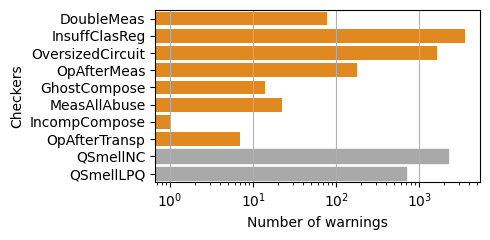

In [69]:
fig, ax = plt.subplots(figsize=(5, 2.5))

# rename the rules with the rule mapping
df = df_all_checker_location.copy()
print(df['rule'].unique())
# add extra column with 0 for QSmell detectors and 1 for the others
df['detector_family'] = df['rule'].map(lambda e: 0 if e.startswith("QSmell") else 1)
# sort by detector family
df = df.sort_values(by=["detector_family"], ascending=False)
# remove the detector family column
df = df.drop(columns=['detector_family'])

sns.countplot(
    data=df,
    y='rule',
    color='darkorange'
    # hue='extension',
)

# recolor the last two bars in gray
for p in ax.patches[-2:]:
    p.set_color('darkgrey')

# set log scale
plt.xscale('log')
# switch on axix
plt.gca().xaxis.grid(True)
plt.xlabel("Number of warnings")
plt.ylabel("Checkers")

# # color the background to separate the two families
# rule_names = df['rule'].unique()
# n_qlint = len([e for e in rule_names if not e.startswith("QSmell")])
# end_qlint_background = len(rule_names) - .25
# start_qlint_background = n_qlint  - .65
# plt.axhspan(
#     start_qlint_background, end_qlint_background, 
#     facecolor='lightgrey', alpha=0.5, zorder = -1)

df_all_checker_location_clean = df

plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, "warnings_per_checker.pdf"),
    bbox_inches='tight'
)


### Table Warnings (tot + per Program) + precision

In [70]:
df_inspected_warnings['detector_rule'].unique()

array(['OpAfterTransp', 'OpAfterMeas', 'GhostCompose', 'DoubleMeas',
       'OversizedCircuit', 'IncompCompose', 'UngovCompose',
       'MeasAllAbuse', 'InsuffClasReg', 'QSmellNC', 'QSmellLPQ'],
      dtype=object)

In [73]:
df = df_inspected_warnings.copy()
df['present_in_last_experiment'] = df['present_in_last_experiment'].astype(bool)
df = df[df['present_in_last_experiment']]

# count the number of tp / the total number of inspected warnings
df_inspected_tp_warnings = df[df['triage'] == 'TP']
df_inspected_tp_warnings_count = \
    df_inspected_tp_warnings.groupby('detector_rule').agg({'triage': 'count'})  
df_inspected_tp_warnings_count.reset_index(inplace=True)
df_inspected_tp_warnings_count.rename(columns={'triage': 'tp'}, inplace=True)

# count total inspection per detector_rule
df_inspected_warnings_count = \
    df.groupby('detector_rule').agg({'triage': 'count'})
df_inspected_warnings_count.reset_index(inplace=True)
df_inspected_warnings_count.rename(columns={'triage': 'total'}, inplace=True)

# merge
df_precision = pd.merge(
    df_inspected_tp_warnings_count,
    df_inspected_warnings_count,
    how='right',
    on='detector_rule',
)
df_precision.fillna(0, inplace=True)

df_precision['precision'] = (df_precision['tp'] / df_precision['total']) * 100
# as percentage with a decimal
df_precision['precision'] = df_precision['precision'].apply(lambda e: f"{e:.1f}%")
# rename: detector_rule > rule
df_precision = df_precision.rename(columns={'detector_rule': 'rule'})
df_precision

,rule,tp,total,precision
0,DoubleMeas,3.0,10,30.0%
1,GhostCompose,3.0,10,30.0%
2,IncompCompose,0.0,1,0.0%
3,InsuffClasReg,0.0,22,0.0%
4,MeasAllAbuse,9.0,10,90.0%
5,OpAfterMeas,6.0,13,46.2%
6,OpAfterTransp,7.0,7,100.0%
7,OversizedCircuit,3.0,21,14.3%
8,QSmellLPQ,0.0,10,0.0%
9,QSmellNC,0.0,10,0.0%


In [78]:
df = df_all_checker_location_clean.copy()
# group by program 
df = df.groupby(['rule']).agg({'Location': 'count'})
df.rename(columns={'Location': 'count'}, inplace=True)
df.reset_index(inplace=True)
# add all the rules that are not in the dataframe with 0 warnings
for rule in RULE_NAME_MAPPING.values():
    if rule not in df['rule'].unique():
        df = df.append({'rule': rule, 'count': 0}, ignore_index=True)

# add the normalized warning rate per checker
df['normalized_warning_rate'] = (df['count'] / TOTAL_FILES_IN_DATASET) * 100
# format as percentage with a decimal
df['normalized_warning_rate'] = df['normalized_warning_rate'].map('{:,.1f}%'.format)

# merge with df_precision (keeping the df as base)
df = pd.merge(df, df_precision, on='rule', how='left')
# fillna for each column
# tp > 0 
# total > 0
# precision > X%
df['tp'] = df['tp'].fillna(0).astype(int)
df['total'] = df['total'].fillna(0).astype(int)
df['hidden_precision'] = (df['tp'] / df['total']).fillna(0)
df['precision'] = df['precision'].fillna('~')

# add family column
df['family'] = df['rule'].map(lambda e: "QSmell" if e.startswith("QSmell") else "LintQ")
# sort by family and precision
df = df.sort_values(by=['family', 'hidden_precision'], ascending=[True, False])
avg_precision_qlint = (df[df['family'] == 'LintQ']['hidden_precision'].mean()) * 100
print("\\newcommand{\\avgPrecisionQLint}{" + f"{avg_precision_qlint:.2f}\%" + "}")
# hide the hidden_precision column and the family column
df = df.drop(columns=['hidden_precision', 'family'])

# sort by canonical order
df['rule'] = pd.Categorical(
    df['rule'],
    categories=RULE_NAME_MAPPING.values()
)
df = df.sort_values('rule')

# rename columns:
# rule > Checker
# count > Number of warnings
# normalized_warning_rate > Warnings per file
df = df.rename(columns={
    "rule": "Checker",
    "count": "Tot.",
    "normalized_warning_rate": "Ratio",
    "precision": "Precision",
    "tp": "TP",
    "total": "Tot.",
})
table = df.to_latex(index=False, column_format="lrrrrr")
# add the multicolumn after the first toprule
table = table.replace(
    r"\toprule",
    r"\toprule \multicolumn{1}{l}{} & \multicolumn{2}{c}{Warnings} & \multicolumn{3}{c}{Manual inspection} \\" + "\n" + r"\cmidrule{2-6}",
    1
)
# add a midrule before the first occurrences of QSmell
table = table.replace(
    r"QSmell",
    r"\midrule" + "\n" + "QSmell",
    1
)
print(table)
df.head(20)

\newcommand{\avgPrecisionQLint}{34.49\%}
\begin{tabular}{lrrrrr}
\toprule \multicolumn{1}{l}{} & \multicolumn{2}{c}{Warnings} & \multicolumn{3}{c}{Manual inspection} \\
\cmidrule{2-6}
         Checker &  Tot. & Ratio &  TP &  Tot. & Precision \\
\midrule
      DoubleMeas &    78 &  1.0\% &   3 &    10 &     30.0\% \\
     OpAfterMeas &   178 &  2.4\% &   6 &    13 &     46.2\% \\
    MeasAllAbuse &    22 &  0.3\% &   9 &    10 &     90.0\% \\
   IncompCompose &     1 &  0.0\% &   0 &     1 &      0.0\% \\
    UngovCompose &     0 &  0.0\% &   0 &     0 &         \textasciitilde  \\
    GhostCompose &    14 &  0.2\% &   3 &    10 &     30.0\% \\
   InsuffClasReg &  3585 & 47.4\% &   0 &    22 &      0.0\% \\
OversizedCircuit &  1622 & 21.4\% &   3 &    21 &     14.3\% \\
   OpAfterTransp &     7 &  0.1\% &   7 &     7 &    100.0\% \\
        \midrule
QSmellNC &  2218 & 29.3\% &   0 &    10 &      0.0\% \\
       QSmellLPQ &   698 &  9.2\% &   0 &    10 &      0.0\% \\
\bottomrule
\end{t

/tmp/ipykernel_6288/222068581.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'rule': rule, 'count': 0}, ignore_index=True)
/tmp/ipykernel_6288/222068581.py:55: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=False, column_format="lrrrrr")


,Checker,Tot.,Ratio,TP,Tot.,Precision
0,DoubleMeas,78,1.0%,3,10,30.0%
5,OpAfterMeas,178,2.4%,6,13,46.2%
4,MeasAllAbuse,22,0.3%,9,10,90.0%
2,IncompCompose,1,0.0%,0,1,0.0%
10,UngovCompose,0,0.0%,0,0,~
1,GhostCompose,14,0.2%,3,10,30.0%
3,InsuffClasReg,3585,47.4%,0,22,0.0%
7,OversizedCircuit,1622,21.4%,3,21,14.3%
6,OpAfterTransp,7,0.1%,7,7,100.0%
9,QSmellNC,2218,29.3%,0,10,0.0%


### RQ3.B False Positive Estimate (via samples)

In [79]:
df_warnings['rule'].value_counts()

ql-unmeasurable-qubits            3585
qsmell-nc                         2091
qsmell-lpq                        1669
ql-oversized-circuit              1622
ql-operation-after-measurement     178
ql-token-leakage                   153
ql-double-measurement               78
ql-measure-all-abuse                22
ql-ghost-composition                14
ql-op-after-optimization             7
ql-incompatible-composition          1
Name: rule, dtype: int64

In [80]:
RULE_NAME_MAPPING

{'ql-double-measurement': 'DoubleMeas',
 'ql-operation-after-measurement': 'OpAfterMeas',
 'ql-measure-all-abuse': 'MeasAllAbuse',
 'ql-incompatible-composition': 'IncompCompose',
 'ql-ungoverned-composition': 'UngovCompose',
 'ql-ghost-composition': 'GhostCompose',
 'ql-unmeasurable-qubits': 'InsuffClasReg',
 'ql-oversized-circuit': 'OversizedCircuit',
 'ql-op-after-optimization': 'OpAfterTransp',
 'qsmell-nc': 'QSmellNC',
 'qsmell-lpq': 'QSmellLPQ'}

{'ql-double-measurement': 'DoubleMeas (12/78)', 'ql-operation-after-measurement': 'OpAfterMeas (15/178)', 'ql-measure-all-abuse': 'MeasAllAbuse (10/22)', 'ql-incompatible-composition': 'IncompCompose (1/1)', 'ql-ungoverned-composition': 'UngovCompose (0/0)', 'ql-ghost-composition': 'GhostCompose (10/14)', 'ql-unmeasurable-qubits': 'InsuffClasReg (23/3585)', 'ql-oversized-circuit': 'OversizedCircuit (27/1622)', 'ql-op-after-optimization': 'OpAfterTransp (7/7)', 'qsmell-nc': 'QSmellNC (10/2091)', 'qsmell-lpq': 'QSmellLPQ (10/1669)'}


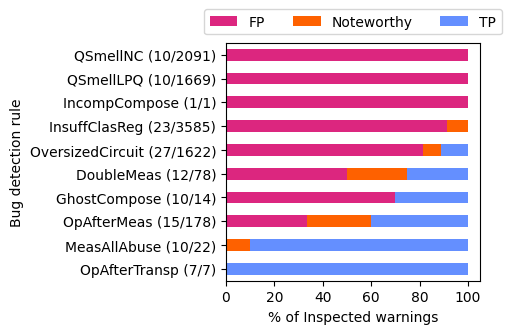

In [81]:
df_inspected_warnings = pd.read_csv(PATH_MANUAL_INSPECTION_CSV)
# filter out blacklisted experiment
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["experiment"].isin(BLACKLIST_EXPERIMENTS)]
# filter out blacklisted
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["detector_rule"].isin(BLACKLISTED_RULES)]
# remove zero warnings detectors
non_zero_warning_detectors = df_warnings['rule'].value_counts().keys()
df_inspected_warnings = df_inspected_warnings[
    df_inspected_warnings["detector_rule"].isin(non_zero_warning_detectors)]

from copy import deepcopy
# add the number of warnings per detector in the mapping
rule_name_mapping_w_count = deepcopy(RULE_NAME_MAPPING)
for k, v in rule_name_mapping_w_count.items():
    tot_warning_count = len(df_warnings[df_warnings['rule'] == k])
    inspected_count = len(df_inspected_warnings[df_inspected_warnings['detector_rule'] == k])
    rule_name_mapping_w_count[k] = v + " (" + str(inspected_count) + "/" + str(tot_warning_count) + ")"
print(rule_name_mapping_w_count)

# map the rules with the name mapping
df_inspected_warnings['detector_rule'] = \
    df_inspected_warnings['detector_rule'].map(rule_name_mapping_w_count)
# drop all rows with nan in the experiment column
df_inspected_warnings = df_inspected_warnings.dropna(subset=['experiment'])


cross_tab_prop = pd.crosstab(
    index=df_inspected_warnings['detector_rule'],
    columns=df_inspected_warnings['triage'],
    normalize="index")

cross_tab_prop = cross_tab_prop * 100
# sort by number of TP column 
cross_tab_prop = cross_tab_prop.sort_values(by=["TP", "Noteworthy"], ascending=False)

fig, ax = plt.subplots(figsize=(5, 3.5))
cross_tab_prop.plot(
    kind='barh', 
    stacked=True, 
    color=['#DC267F', '#FE6100', '#648FFF'],
    ax=ax
)
plt.xlabel("% of Inspected warnings")
plt.ylabel("Bug detection rule")
# put legend above the diagram
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=3)
plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, "precision_estimate.pdf"), 
    bbox_inches="tight")


In [82]:
list(df_inspected_warnings['detector_rule'].unique())

['OpAfterTransp (7/7)',
 'OpAfterMeas (15/178)',
 'GhostCompose (10/14)',
 'DoubleMeas (12/78)',
 'OversizedCircuit (27/1622)',
 'IncompCompose (1/1)',
 'MeasAllAbuse (10/22)',
 'InsuffClasReg (23/3585)',
 'QSmellNC (10/2091)',
 'QSmellLPQ (10/1669)']

In [83]:
df = df_inspected_warnings.copy()
df['present_in_last_experiment'] = df['present_in_last_experiment'].astype(bool)
df = df[~df['present_in_last_experiment']]
df.head()

,problem_id,url,snippet,experiment,present_in_last_experiment,unique_id,line,date_found,analysis_results,detector_rule,...,status,added_to_test_suite,IDEA,date_reported,API_usage,link_to_issue,developer_reaction,developer comment,component,known_before
8,06_fd4508_36,https://github.com/CleverCracker/Quantum_Image_Based_Search_Engine/blob/42baeb62714d685a011213fe209cab208154e301/SearchEngine_32x32.py,"for x in range(0, 5):\n qc = QuantumCircuit(targetQubit, ref, original, anc, c)\n qc.initialize(data[index], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 23])\n qc.initialize(data[x], range(12, 24))\n qc.tdg(targetQubit[0])\n qc.h(targetQubit[0])\n for i in range(len(ref)):\n qc.cswap(targetQubit[0], ref[i], original[i])\n qc.h(targetQubit[0])\n qc.tdg(targetQubit[0])\n qc.measure(targetQubit[0], c)",exp_v06,False,searchengine_32x32_fd4508,36.0,6-mar-23,codeql_2023-03-06_13-18-29,OpAfterMeas (15/178),...,NaN,yes,"this should perhaps became a path detector, similar to the sanitization detectors.",NaN,for loop circuit construction,NaN,NaN,NaN,NaN,NaN
16,06_93508a_22,https://github.com/Albisourous/quantumgameoflife/blob/3f320a774eae714e8e17dbdc2601239d3de8a5f8/quantum.py,"for row in range(0, grid_size):\n qc = QuantumCircuit(2, 2)\n qc2 = QuantumCircuit(2, 2)\n # 00 or 11\n qc.h(0)\n qc.cx(0, 1)\n qc.ry((np.pi/3), 0)\n qc.measure([0, 1], [0, 1])",exp_v06,False,quantum_93508a,22.0,6-mar-23,codeql_2023-03-06_13-18-27,OpAfterMeas (15/178),...,NaN,yes,"this should perhaps became a path detector, similar to the sanitization detectors.",NaN,for loop circuit construction,NaN,NaN,NaN,NaN,NaN
49,06_83eb33_23,https://github.com/hkhetawat/QArithmetic/blob/a9950caf15aeda5cb7d45c327a457d773268bf54/examples/test_rev_pow.py,"# Input N\nN = 2\nX = 2 # qc will take exponentially longer to compile with each increase\na = QuantumRegister(N)\nb = QuantumRegister(X)\nm = QuantumRegister(N*(pow(2,X)-1))\nca = ClassicalRegister(N)\ncm = ClassicalRegister(N*(pow(2,X)-1))\nqc = QuantumCircuit(a, b, m, cm, ca)",exp_v06,False,test_rev_pow_83eb33,23.0,10-mar-23,codeql_2023-03-08_15-15-36,InsuffClasReg (23/3585),...,NaN,NaN,"if there is at least an unknown reg size we disable the warning, or we decide to model simple expressions (e.g. addition)",NaN,circuit size,NaN,NaN,NaN,NaN,NaN
53,06_061e13_39,https://github.com/sungmin-net/Qiskit_Tutorials/blob/579df0293d478e197bcaa579855aa6971354359f/tutorial03_QuantumOperations.py,"qc = QuantumCircuit(q)\nqc.u2(pi / 2, pi / 2, q)\nqc.draw('mpl')\nplt.show()\nplot_bloch_multivector(qc)\nplt.show()\njob = execute(qc, backend)\nprint(job.result().get_unitary(qc, decimals = 3))",exp_v06,False,tutorial03_quantumoperations_061e13,39.0,8-mar-23,codeql_2023-03-06_13-18-39,OversizedCircuit (27/1622),...,NaN,yes,NaN,NaN,plotting intent,NaN,NaN,NaN,NaN,NaN
66,06_23d6b0_22,https://github.com/ahmedkfu2020/-/blob/a205805a9dfaef2f8cb2ff0645c597b1b119747c/ahmed23_2.py,"for i in range(1,12):\n # quantum circuit with one qubit and one bit\n qreg = QuantumRegister(1) \n creg = ClassicalRegister(1) \n mycircuit = QuantumCircuit(qreg,creg)\n # the stream of length i\n for j in range(i):\n mycircuit.ry(2*theta,qreg[0]) # apply one rotation for each symbol\n mycircuit.measure(qreg[0],creg[0])",exp_v06,False,ahmed23_2_23d6b0,22.0,7-mar-23,codeql_2023-03-06_13-18-30,DoubleMeas (12/78),...,NaN,yes,"keep only warnings without circuit initialization along the path, get inspired by sanitization.",NaN,mid-circuit measurements,NaN,NaN,NaN,NaN,NaN


In [84]:
df_inspected_warnings['triage'].unique()

array(['TP', 'FP', 'Noteworthy'], dtype=object)

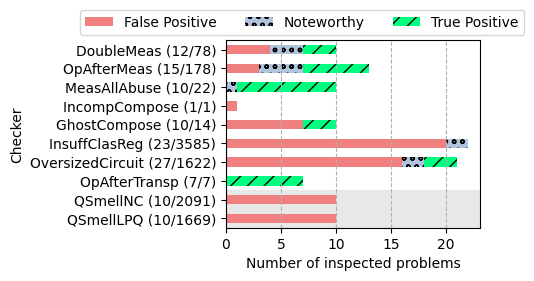

In [98]:
sample_size = 10

# create a stacked histogram of the number of inspected warnings per detector
fig, ax = plt.subplots(figsize=(5, 3))

# create dataframe with detection_rule, TP, Noteworthy, FP
# which come from detection_rule and triage
df = df_inspected_warnings.copy()
df['present_in_last_experiment'] = df['present_in_last_experiment'].astype(bool)
df = df[df['present_in_last_experiment']]
df_stacked_hist = df[['detector_rule', 'triage']]
# remove detectors corresponding to zero warnings
df_stacked_hist = df_stacked_hist[df_stacked_hist.sum(axis=1) != 0]
df_stacked_hist = df_stacked_hist.groupby(['detector_rule', 'triage']).size().reset_index(name='count')
df_stacked_hist = df_stacked_hist.pivot(index='detector_rule', columns='triage', values='count')
df_stacked_hist = df_stacked_hist.fillna(0)

# SORTING
# # add extra column with 0 for QSmell detectors and 1 for the others
# df_stacked_hist['detector_family'] = df_stacked_hist.index.map(
#     lambda e: 0 if e.startswith("QSmell") else 1)
# # sort by detector family
# df_stacked_hist = df_stacked_hist.sort_values(by=["TP", "Noteworthy", "FP"], ascending=False)
# df_stacked_hist = df_stacked_hist.sort_values(by=["detector_family"], ascending=True)
# convert from DoubleMeas (10/20) >> DoubleMeas
df_stacked_hist['auxiliary'] = df_stacked_hist.index
df_stacked_hist['rule'] = df_stacked_hist['auxiliary'].apply(
    lambda e: e.split(" (")[0])
# sort by canonical order
df_stacked_hist['rule'] = pd.Categorical(
    df_stacked_hist['rule'],
    categories=RULE_NAME_MAPPING.values())
df_stacked_hist = df_stacked_hist.sort_values('rule', ascending=False)
df_stacked_hist = df_stacked_hist.drop(columns=[
    'rule', 'auxiliary'])
# df_stacked_hist = df_stacked_hist.drop(columns=[
#     'detector_family'])

MAPPING_CATEGORY_NAMES = {
    "TP": "True Positive",
    "Noteworthy": "Noteworthy",
    "FP": "False Positive"
}
df_stacked_hist = df_stacked_hist.rename(columns=MAPPING_CATEGORY_NAMES)


df_stacked_hist.plot(
    kind='barh',
    stacked=True,
    color=['lightcoral', 'lightsteelblue', 'springgreen'],
    ax=ax 
)

# add the hatches to the bars.
# each color should have a different hatch
hatches_available = ['', 'oo', '//']
hatches_assigned = 0
all_colors = {}
for i, i_bar in enumerate(ax.patches):
    i_color = i_bar.get_facecolor()
    if i_color not in all_colors.keys():
        all_colors[i_color] = hatches_available[hatches_assigned]
        hatches_assigned += 1
    i_bar.set_hatch(all_colors[i_color]) 
    
# color the background to separate the two families
n_qsmell_detectors = len(
    df_stacked_hist[df_stacked_hist.index.str.startswith("QSmell")])
separation_line = n_qsmell_detectors - .5
plt.axhspan(separation_line, -1, facecolor='lightgrey', alpha=0.5, zorder = -1)

# remove title from the legend
plt.legend(
    title=None,
    loc='upper center', bbox_to_anchor=(0.3, 1.2), ncol=3)

# add the labels
plt.xlabel("Number of inspected problems")
plt.ylabel("Checker")

# add vertical grid
plt.grid(axis='x', linestyle='--')

# draw line at the sample size in red
# plt.axvline(x=sample_size, color='r', linestyle='--')
plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, "precision_estimate_abs.pdf"), 
    bbox_inches="tight")

# RQ5: Efficiency

In [64]:


log_content = open(LOG_FILE_QUERIES, 'r').read()
log_content_db = open(LOG_FILE_DB_CREATION, 'r').read()
# modules in 4447.50s
for db_log_line in log_content_db.splitlines():
    if " modules in " in db_log_line:
        #print(db_log_line)
        total_time_db = float(re.findall(r'modules in (\d+\.?\d+?)s', db_log_line)[0])


# a line looks like this
# [1/14 comp 9.1s] Compiled /home/paltenmo/projects/qlint/qlint/codeql/src/Interconnection/GhostComposition.ql.
# parse the time and the file name
lines = log_content.splitlines()
compilation_lines = [l for l in lines if "Compiled" in l]
compilation_times = {
    re.findall(r'([a-zA-Z]+)\.ql\.$', l)[0] : float(re.findall(r'(\d+\.?\d?)s', l)[0])
    for l in compilation_lines
}
evaluation_lines = [l for l in lines if "Evaluation done" in l]
evaluation_times = {}
for l in evaluation_lines:
    key =  re.findall(r'([a-zA-Z]+)\.bqrs\.$', l)[0]
    seconds = float(re.findall(r'(\d+\.?\d?)s', l)[0])
    if minutes_regex := re.findall(r'(\d+\.?\d?)m', l):
        seconds += float(minutes_regex[0]) * 60
    evaluation_times[key] = seconds
evaluation_times

# create a dataframe with the compilation and evaluation times
df_times = pd.DataFrame.from_dict(
    {
        'compilation_time': compilation_times,
        'evaluation_time': evaluation_times
    }
)
df_times.reset_index(inplace=True)
df_times.rename(columns={'index': 'detector_rule'}, inplace=True)

# remove blacklisted detectors
BLACKLISTED_QUERY = [
    'NonParametrizedCircuit',
    'TokenLeakage',
    'NoAlignmentLogicalPhysical',
    'InvalidPauliSyntaxError',
    'InvalidPauliErrorSize',
]
df_times = df_times[
    ~df_times['detector_rule'].isin(BLACKLISTED_QUERY)]
df_times.reset_index(drop=True, inplace=True)

avg_comp_time = df_times['compilation_time'].mean()
avg_exec_time = df_times['evaluation_time'].mean()
print("\\newcommand{\\avgPerDetectorQueryCompilationTimeSec}{" + f"{avg_comp_time:.1f}" + "}")
print("\\newcommand{\\avgPerDetectorEvaluationTimeSec}{" + f"{avg_exec_time:.1f}" + "}")

total_comp_time = df_times['compilation_time'].sum()
total_exec_time = df_times['evaluation_time'].sum()
total_exec_time_min = total_exec_time / 60
print("\\newcommand{\\totalDatasetQueryCompilationTimeSec}{" + f"{total_comp_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeSec}{" + f"{total_exec_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeMin}{" + f"{total_exec_time_min:.0f}" + "}")


total_time_db_min = total_time_db / 60
print("\\newcommand{\\totalDatasetCreationTimeSec}{" + f"{total_time_db:.1f}" + "}")
print("\\newcommand{\\totalDatasetCreationTimeMin}{" + f"{total_time_db_min:.0f}" + "}")

normalized_time_per_query = total_exec_time / TOTAL_FILES_IN_DATASET
print("\\newcommand{\\avgPerProgramEvaluationTimeSec}{" + f"{normalized_time_per_query:.1f}" + "}")

df_times

\newcommand{\avgPerDetectorQueryCompilationTimeSec}{6.5}
\newcommand{\avgPerDetectorEvaluationTimeSec}{575.9}
\newcommand{\totalDatasetQueryCompilationTimeSec}{58.4}
\newcommand{\totalDatasetEvaluationTimeSec}{5182.8}
\newcommand{\totalDatasetEvaluationTimeMin}{86}
\newcommand{\totalDatasetCreationTimeSec}{4447.5}
\newcommand{\totalDatasetCreationTimeMin}{74}
\newcommand{\avgPerProgramEvaluationTimeSec}{0.7}


,detector_rule,compilation_time,evaluation_time
0,GhostComposition,9.1,53.7
1,UngovernedComposition,5.3,42.8
2,IncompatibleComposition,5.3,43.8
3,OpAfterOptimization,4.4,43.8
4,MeasureAll,7.0,51.9
5,OpAfterMeasurement,7.0,3328.0
6,DoubleMeasurement,7.2,1426.0
7,UnmeasurableQubits,6.0,43.8
8,OversizedCircuit,7.1,149.0


In [65]:
# get the top three detector rules per evaluation time
df = df_times.copy()
df.sort_values(by='evaluation_time', ascending=False, inplace=True)
df = df.head(3)
number_prefixes = ['One', 'Two', 'Three']
i = 0
for _, row in df.iterrows():
    name = row['detector_rule']
    time = row['evaluation_time']
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "}{" + name + "}")
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "TimeSec}{" + f"{time:.1f}" + "}")
    i += 1



\newcommand{\topThreeDetectorRuleOne}{OpAfterMeasurement}
\newcommand{\topThreeDetectorRuleOneTimeSec}{3328.0}
\newcommand{\topThreeDetectorRuleTwo}{DoubleMeasurement}
\newcommand{\topThreeDetectorRuleTwoTimeSec}{1426.0}
\newcommand{\topThreeDetectorRuleThree}{OversizedCircuit}
\newcommand{\topThreeDetectorRuleThreeTimeSec}{149.0}


# Miscellanea

In [ ]:
# create bipartite graph of abstractions and queries
import networkx as nx
import matplotlib.pyplot as plt


FONT_SIZE = 12
FONT_FAMILY = 'monospace'
fig, ax = plt.subplots(figsize=(6, 3))
# zoom out to make all the nodes visible
plt.xlim(-3, 3)
G = nx.DiGraph()

# use monospace font

# codeql color background: E8FAFC

# add all queries: color them #E8FAFC
for query_name in query_to_abstraction.keys():
    G.add_node(query_name, bipartite=1)


# add all abstractions: color them orange
for abstractions in query_to_abstraction.values():
    for abstraction in abstractions:
        G.add_node(abstraction, bipartite=0)

# add edges: directed from query to abstraction
for query_name, abstractions in query_to_abstraction.items():
    for abstraction in abstractions:
        G.add_edge(query_name, abstraction)
        
# place all abstractions on the left
pos = nx.bipartite_layout(G, nodes=[
    n 
    for n, d in G.nodes(data=True) 
    if d['bipartite'] == 1]
)


color_map = []
left_nodes = []
right_nodes = []
pos_left = {}
pos_right = {}
for node in G:
    if node in query_to_abstraction.keys():
        color_map.append('slateblue')
        left_nodes.append(node)
        pos_left[node] = pos[node]
    else:
        color_map.append('gold')
        right_nodes.append(node)
        pos_right[node] = pos[node]

G_left_nodes = G.subgraph(left_nodes)
G_right_nodes = G.subgraph(right_nodes)

nx.draw(
    G, pos=pos,
    node_color=color_map,
    arrowstyle='-',
    edge_color='darkgray',
    ax=ax
)
nx.draw_networkx_labels(
    G_left_nodes, pos=pos_left,
    font_size=FONT_SIZE,
    font_family=FONT_FAMILY,
    horizontalalignment='right'
)


nx.draw_networkx_labels(
    G_right_nodes, pos=pos_right,
    font_size=FONT_SIZE,
    font_family=FONT_FAMILY,
    horizontalalignment='left'
)


# for node in G:
#     print(node, pos[node])

# # get all the references to the text of the labels
# labels = {t.get_text(): t for t in ax.get_children() if isinstance(t, plt.Text)}

# # plot a letter and get the size of it when rendered
# t = plt.text(0, 0, 'A', fontsize=FONT_SIZE, family='monospace')
# char_width = t.get_window_extent().width / plt.gcf().dpi
# print("char_width: ", char_width)
# # remove the letter
# t.remove()




# # print their content and location
# for label, text in labels.items():
#     location = text.get_position()
#     print(label, location)
#     # remove it 
#     if label.strip() != '':
#         text.remove()
#     x, y = location
#     length = len(label)
#     base_distance = 1.5
#     if not label in query_to_abstraction.keys():
#         x_shift = base_distance * char_width 
#     else:
#         x_shift = - ((length) * char_width) 
#     new_x = x + x_shift
#     new_y = y
#     t = plt.text(
#         new_x,
#         new_y,
#         label,
#         fontsize=FONT_SIZE,
#         family='monospace',

#     )
#     t.set_clip_on(False)
plt.tight_layout(
    pad=1,
)
fig.savefig(
    os.path.join(PAPER_DIR, 'abstraction_graph.pdf'))

In [107]:
df_times["normalized_evaluation_time"] = df_times["evaluation_time"] / TOTAL_FILES_IN_DATASET
# make it flat
df_times_flat = df_times.melt(
    id_vars=['detector_rule'],
    value_vars=['compilation_time', 'normalized_evaluation_time'],
    var_name='type',
    value_name='time'
)
df_times_flat

,detector_rule,type,time
0,GhostComposition,compilation_time,9.100000
1,UngovernedComposition,compilation_time,5.300000
2,IncompatibleComposition,compilation_time,5.300000
3,OpAfterOptimization,compilation_time,4.400000
4,MeasureAll,compilation_time,7.000000
5,OpAfterMeasurement,compilation_time,7.000000
6,DoubleMeasurement,compilation_time,7.200000
7,NoAlignmentLogicalPhysical,compilation_time,5.600000
8,NonParametrizedCircuit,compilation_time,6.100000
9,TokenLeakage,compilation_time,5.100000


\newcommand{\avgTimeCompilationSec}{6.16}
\newcommand{\avgTimeEvaluationSec}{0.05}


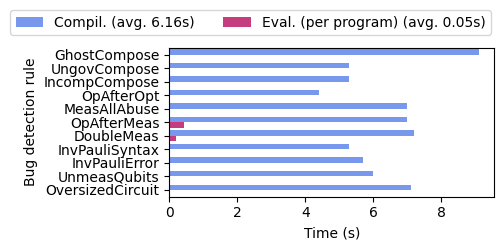

In [138]:
fig, ax = plt.subplots(figsize=(5, 2.8))
df = df_times_flat.copy()
map_timed_values = {
    'compilation_time': 'Compilation',
    'normalized_evaluation_time': 'Evaluation'
}
df['type'] = df['type'].map(map_timed_values)

filename_mapping_no_ql_ext = {
    k.split(".")[0] : v
    for k, v in FILE_NAME_RULE_MAPPING.items()
}
df['detector_rule'] = df['detector_rule'].map(filename_mapping_no_ql_ext)

sns.barplot(
    data=df,
    y='detector_rule',
    x='time',
    hue='type',
    hue_order=['Compilation', 'Evaluation'],
    palette=['#648FFF', '#DC267F'],
    ax=ax
)
avg_exec_time = df_times_flat[
    df_times_flat['type'] == 'normalized_evaluation_time'
]['time'].mean()

avg_comp_time = df_times_flat[
    df_times_flat['type'] == 'compilation_time'
]['time'].mean()


plt.xlabel("Time (s)")
plt.ylabel("Bug detection rule")
# put the legend above in the center on two columns
texts = plt.legend(
    title=None, 
    loc='upper center',
    bbox_to_anchor=(0.25, 1.3),
    ncol=2
).get_texts()
texts[0].set_text(f"Compil. (avg. {avg_comp_time:.2f}s)")
texts[1].set_text(f"Eval. (per program) (avg. {avg_exec_time:.2f}s)")


plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, "time_efficiency.pdf"),
    bbox_inches="tight"
)

print("\\newcommand{\\avgTimeCompilationSec}{" + f"{avg_comp_time:.2f}" + "}")
print("\\newcommand{\\avgTimeEvaluationSec}{" + f"{avg_exec_time:.2f}" + "}")
    

In [ ]:
# Abstractions and Qiskit API mapping 

import re

PATH_MAPPING_TABLE_CSV = "mapping_table.csv"
df = pd.read_csv(PATH_MAPPING_TABLE_CSV)
latex_table = df.to_latex(
    index=False,
    column_format="l>{\columncolor{backcolour}}llll")
# replace all NaN with empty space
latex_table = re.sub(r'NaN', '', latex_table)
# replace anything between two stars with a highlight
lines = latex_table.splitlines()
new_lines = []
for i, line in enumerate(lines):
    # whenever the line starts with a letter, add a midrule
    if re.findall(r'^[a-zA-Z]', line.strip()):
        #print(line.strip())
        new_lines.append('\\midrule')
    new_line = line
    # highlight program elements surrounded by *
    new_line = new_line.replace('*', '\\hlpastel{', 1)
    new_line = new_line.replace('*', '}', 1)
    # make bold string surrounded by $
    while '?' in new_line:
        new_line = new_line.replace('?', '\\textbf{', 1)
        new_line = new_line.replace('?', '}', 1)
    # color in blue string surrounded by ^
    while '|' in new_line:
        new_line = new_line.replace('|', '\\textcolor{blue}{', 1)
        new_line = new_line.replace('|', '}', 1)
    new_lines.append(new_line)
latex_table = '\n'.join(new_lines)
# convert \toprule\n\midrule to \toprule
latex_table = latex_table.replace('\\toprule\n\\midrule', '\\toprule')
# convert \midrule\n\midrule to \midrule
latex_table = latex_table.replace('\\midrule\n\\midrule', '\\midrule')

print(latex_table)
df.head()